<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/03b_creating_a_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Creating a dataset

This tutorial provides a short example on how to create a SeisBench dataset. Datasets can be created from any event catalog and waveform collection. For this example, we download an event catalog for Switzerland through FDSN. We will then download the associated waveforms through FDSN as well. We use built-in SeisBench functions for writing out the dataset in SeisBench format. In this example notebook we aim for an easy example outlining the principles of dataset creation. There are a few further considerations, in particular, for converting larger datasets, that we outline at the end.

**Note:** Some familiarity with obspy and its FDSN client is helpful for this tutorial, but not required.

In [1]:
import seisbench
import seisbench.data as sbd
import seisbench.util as sbu

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException
import matplotlib.pyplot as plt
from pathlib import Path

#### The event catalog

As a first step, we need an event catalog. Here, we are going to use the catalog provided by ETHZ over FDSN. For demonstration purposes, we only use a short time window.

In [2]:
client = Client("ETH", timeout=10)

In [3]:
t0 = UTCDateTime(2015, 1, 1)
t1 = t0 + 10 * 24 * 60 * 60  # Ten days

In [4]:
catalog = client.get_events(t0, t1, includearrivals=True)
print(catalog.__str__(print_all=True))

32 Event(s) in Catalog:
2015-01-10T17:37:42.085490Z | +45.867,  +10.708 | 1.82 MLh | manual
2015-01-10T10:22:02.039806Z | +45.872,  +10.698 | 1.77 MLh | manual
2015-01-10T08:12:24.456183Z | +47.281,   +7.237 | 0.97 MLh | manual
2015-01-09T23:49:49.012842Z | +47.887,   +8.234 | 2.32 MLh | manual
2015-01-09T07:03:06.992355Z | +47.069,   +9.495 | 0.30 MLh | manual
2015-01-09T03:18:25.808029Z | +46.678,  +10.050 | 0.77 MLh | manual
2015-01-09T02:16:37.962913Z | +46.678,  +10.060 | 0.94 MLh | manual
2015-01-08T10:43:16.036465Z | +47.547,   +8.167 | 1.66 MLh | manual
2015-01-08T08:23:19.715674Z | +45.984,   +6.995 | 0.67 MLh | manual
2015-01-08T06:22:34.108154Z | +47.368,  +10.116 | 1.02 MLh | manual
2015-01-08T02:15:23.147104Z | +46.677,  +10.060 | 0.98 MLh | manual
2015-01-07T19:55:04.223164Z | +46.675,  +10.046 | 0.92 MLh | manual
2015-01-07T15:28:50.880383Z | +46.024,   +6.893 | 0.47 MLh | manual
2015-01-07T12:25:10.882856Z | +46.195,   +6.921 | 0.26 MLh | manual
2015-01-07T11:59:34.8589

#### Extracting the event parameters

From the catalog, we extract the event parameters and store them into a dictionary. Here, we only extract a few basic parameters on the source and its magnitude - if available. In addition, we define the split of the dataset into training/development/test partitions. We visualize one example.

In [5]:
def get_event_params(event):
    origin = event.preferred_origin()
    mag = event.preferred_magnitude()

    source_id = str(event.resource_id)

    event_params = {
        "source_id": source_id,
        "source_origin_time": str(origin.time),
        "source_origin_uncertainty_sec": origin.time_errors["uncertainty"],
        "source_latitude_deg": origin.latitude,
        "source_latitude_uncertainty_km": origin.latitude_errors["uncertainty"],
        "source_longitude_deg": origin.longitude,
        "source_longitude_uncertainty_km": origin.longitude_errors["uncertainty"],
        "source_depth_km": origin.depth / 1e3,
        "source_depth_uncertainty_km": origin.depth_errors["uncertainty"] / 1e3,
    }

    if mag is not None:
        event_params["source_magnitude"] = mag.mag
        event_params["source_magnitude_uncertainty"] = mag.mag_errors["uncertainty"]
        event_params["source_magnitude_type"] = mag.magnitude_type
        event_params["source_magnitude_author"] = mag.creation_info.agency_id
    
        if str(origin.time) < "2015-01-07":
            split = "train"
        elif str(origin.time) < "2015-01-08":
            split = "dev"
        else:
            split = "test"
        event_params["split"] = split
    
    return event_params

get_event_params(catalog[0])

{'source_id': 'smi:ch.ethz.sed/sc3a/2015arwpjf',
 'source_origin_time': '2015-01-10T17:37:42.085490Z',
 'source_origin_uncertainty_sec': None,
 'source_latitude_deg': 45.86654062,
 'source_latitude_uncertainty_km': 0.7343268032,
 'source_longitude_deg': 10.70824349,
 'source_longitude_uncertainty_km': 2.685048076,
 'source_depth_km': 15.109375,
 'source_depth_uncertainty_km': 2.741017218,
 'source_magnitude': 1.822294525,
 'source_magnitude_uncertainty': 0.1849143793,
 'source_magnitude_type': 'MLh',
 'source_magnitude_author': 'SED',
 'split': 'test'}

#### Extracting the trace parameters

From each pick, we extract parameters about the trace and store them in a dictionary. Again, we only extract very basic parameters. We visualize one example.

In [6]:
def get_trace_params(pick):
    net = pick.waveform_id.network_code
    sta = pick.waveform_id.station_code

    trace_params = {
        "station_network_code": net,
        "station_code": sta,
        "trace_channel": pick.waveform_id.channel_code[:2],
        "station_location_code": pick.waveform_id.location_code,
    }

    return trace_params

get_trace_params(catalog[0].picks[0])

{'station_network_code': 'IV',
 'station_code': 'MABI',
 'trace_channel': 'HH',
 'station_location_code': None}

#### Downloading the waveforms

As a last step, we need to access the waveforms. As for the catalog, we download the waveforms from ETHZ via FDSN. Note that not for all picks we can expect to have waveforms available through FDSN, so we just return empty streams if no data is available. We visualize one example.

In [7]:
def get_waveforms(pick, trace_params, time_before=60, time_after=60):
    t_start = pick.time - time_before
    t_end = pick.time + time_after
    
    try:
        waveforms = client.get_waveforms(
            network=trace_params["station_network_code"],
            station=trace_params["station_code"],
            location="*",
            channel=f"{trace_params['trace_channel']}*",
            starttime=t_start,
            endtime=t_end,
        )
    except FDSNException:
        # Return empty stream
        waveforms = obspy.Stream()
    
    return waveforms
    
pick = catalog[1].picks[5]
trace_params = get_trace_params(pick)
get_waveforms(pick, trace_params)

3 Trace(s) in Stream:
CH.VDL..HHE | 2015-01-10T10:21:22.746700Z - 2015-01-10T10:23:22.746700Z | 120.0 Hz, 14401 samples
CH.VDL..HHN | 2015-01-10T10:21:22.746767Z - 2015-01-10T10:23:22.746767Z | 120.0 Hz, 14401 samples
CH.VDL..HHZ | 2015-01-10T10:21:22.746700Z - 2015-01-10T10:23:22.746700Z | 120.0 Hz, 14401 samples

#### Writing to SeisBench format

Now, we can combine all the above functions together to write a dataset in SeisBench format. For this, we first need to define the path. For this example, we are using the current working directory. A dataset consists of 2 components: 
 - a metadata file, always called `metadata.csv`, which contains all the associated properties of the waveform examples (e.g. trace parameters, source parameters etc.).
 - a waveforms file, always called `waveforms.hdf5`, containing the raw waveforms.

In [8]:
base_path = Path(".")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"

To write the dataset, we use the `WaveformDataWriter` provided by SeisBench. The writer should always be used as a context manager, i.e., using the `with` statement, as shown below. This is to ensure files are properly clsoed after writing and teardown and cleanup operations are always called when exiting the context manager.

First, we need to set the data format for our dataset. We do this by assigning a dictionary to the `writer.data_format` group.

Next, we iterate over all event and all picks in the events. Using the functions above, we generate the event and trace metadata and download the waveforms. We then convert the waveforms to a numpy array using the function `stream_to_array` provided in `seisbench.util`.

As a last step, we hand the event metadata and the waveforms as numpy array over to the writer using `add_trace`. The writer then automatically takes care of writing out the data in the correct format. It also takes care of performance optimisations that we outline in the further considerations below.

In [9]:
# Iterate over events and picks, write to SeisBench format
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
    
    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    
    for event in catalog:
        event_params = get_event_params(event)
        for pick in event.picks:
            trace_params = get_trace_params(pick)
            waveforms = get_waveforms(pick, trace_params)
            
            if len(waveforms) == 0:
                # No waveform data available
                continue
        
            sampling_rate = waveforms[0].stats.sampling_rate
            # Check that the traces have the same sampling rate
            assert all(trace.stats.sampling_rate == sampling_rate for trace in waveforms)
            
            actual_t_start, data, _ = sbu.stream_to_array(
                waveforms,
                component_order=writer.data_format["component_order"],
            )
            
            trace_params["trace_sampling_rate_hz"] = sampling_rate
            trace_params["trace_start_time"] = str(actual_t_start)
            
            sample = (pick.time - actual_t_start) * sampling_rate
            trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(sample)
            trace_params[f"trace_{pick.phase_hint}_status"] = pick.evaluation_mode
            
            writer.add_trace({**event_params, **trace_params}, data)

Traces converted: 354it [02:47,  2.11it/s]


### Loading the dataset

Now that the dataset conversion is finished, we can check it by simply loading it. Here we load the dataset, print the metadata and visualize the first waveform together with the annotated pick.

In [13]:
data = sbd.WaveformDataset(base_path, sampling_rate=100)

In [14]:
print("Training examples:", len(data.train()))
print("Development examples:", len(data.dev()))
print("Test examples:", len(data.test()))

Training examples: 200
Development examples: 62
Test examples: 92


In [15]:
data.metadata

,source_id,source_origin_time,source_origin_uncertainty_sec,source_latitude_deg,source_latitude_uncertainty_km,source_longitude_deg,source_longitude_uncertainty_km,source_depth_km,source_depth_uncertainty_km,source_magnitude,...,trace_Pg_arrival_sample,trace_Pg_status,trace_Sg_arrival_sample,trace_Sg_status,trace_SmS_arrival_sample,trace_SmS_status,trace_PmP_arrival_sample,trace_PmP_status,trace_chunk,trace_component_order
0,smi:ch.ethz.sed/sc3a/2015aridye,2015-01-10T10:22:02.039806Z,NaN,45.872266,0.853350,10.698346,3.152086,14.753906,2.197650,1.771049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
1,smi:ch.ethz.sed/sc3a/2015aridye,2015-01-10T10:22:02.039806Z,NaN,45.872266,0.853350,10.698346,3.152086,14.753906,2.197650,1.771049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
2,smi:ch.ethz.sed/sc3a/2015ardtuy,2015-01-10T08:12:24.456183Z,NaN,47.281218,1.198951,7.237258,0.646997,18.181641,1.401034,0.966449,...,14999.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
3,smi:ch.ethz.sed/sc3a/2015ardtuy,2015-01-10T08:12:24.456183Z,NaN,47.281218,1.198951,7.237258,0.646997,18.181641,1.401034,0.966449,...,7200.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
4,smi:ch.ethz.sed/sc3a/2015ardtuy,2015-01-10T08:12:24.456183Z,NaN,47.281218,1.198951,7.237258,0.646997,18.181641,1.401034,0.966449,...,NaN,NaN,7200.0,manual,NaN,NaN,NaN,NaN,,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,smi:ch.ethz.sed/sc3a/2015aatjqk,2015-01-01T09:44:27.010972Z,NaN,46.914972,0.202352,9.222275,0.210176,3.848633,0.766409,2.682145,...,NaN,NaN,NaN,NaN,NaN,NaN,29999.0,manual,,ZNE
350,smi:ch.ethz.sed/sc3a/2015aatjqk,2015-01-01T09:44:27.010972Z,NaN,46.914972,0.202352,9.222275,0.210176,3.848633,0.766409,2.682145,...,NaN,NaN,NaN,NaN,NaN,NaN,7199.0,manual,,ZNE
351,smi:ch.ethz.sed/sc3a/2015aatjqk,2015-01-01T09:44:27.010972Z,NaN,46.914972,0.202352,9.222275,0.210176,3.848633,0.766409,2.682145,...,NaN,NaN,NaN,NaN,7200.0,manual,NaN,NaN,,ZNE
352,smi:ch.ethz.sed/sc3a/2015aatjqk,2015-01-01T09:44:27.010972Z,NaN,46.914972,0.202352,9.222275,0.210176,3.848633,0.766409,2.682145,...,NaN,NaN,NaN,NaN,NaN,NaN,7199.0,manual,,ZNE


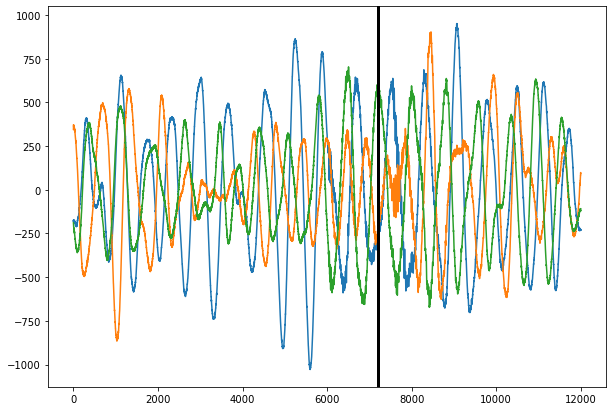

In [16]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(data.get_waveforms(0).T)
ax.axvline(data.metadata["trace_P1_arrival_sample"].iloc[0], color="k", lw=3)

## Considerations for converting datasets

As outlined above, this tutorial provides a very minimal example on converting a dataset. Here we outline additional consideration that should be taken into account when preparing a dataset.

- **Grouping picks**: In this example, we created one trace for each pick. Naturally, traces will overlap if multiple picks, e.g., P and S phases, are available for an event at a station. For an example implementation of this grouping operation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L109) and in the subsequent lines.
- **Adding station information**: In this example, we added no station information except its name. In practice, it will often be helpful for users to incorporate, for example, the location of the station. We skipped this step here, because it requires loading station inventories through FDSN. For an example implementation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L315).
- **Memory requirements**: Internally, the `WaveformDataWriter` writes out the the waveforms continuously in blocks (see point below), but keeps all metadata in memory until the dataset is complete. For very large datasets (or very detailed metadata) this can result in several gigabytes of memory consumption. If you are writing such datasets, make sure the available memory on your machine is sufficient.
- **Waveform blocks**: Instead of writing each waveform separately, waveforms are written out in blocks. This massively improves IO performance. Have a look at [the documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks) for details on the strategy. We expect that in nearly all cases using the default setting will be a good choice.
- **FDSN considerations**: When converting very large datasets, the performance might be limited by the performance of the FDSN webservice. Unfortunately, downloading lots of short waveforms (as required for many machine learning applications) does not seem to be the most favorable use case for FDSN. This leads to rather slow performance when naively downloading the waveforms as outlined above. Instead, it is often helpful to issue [bulk requests](https://docs.obspy.org/master/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms_bulk.html). In addition, it might be a good choice to first download the waveforms and cache them locally, for example, in .mseed format, and then convert them to SeisBench.

For further details on the data format, check out [the data format specification in the SeisBench documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks).